# Introduction

Detecting outlying data points is messy business. Often the first question is "how do we define an outlier?" quickly followed by "what's the standard procedure for detecting them?" More often than not, in conversations that I see and hear, there's a deal of confusion over why someone may select a certain model for anomaly detection vs. another with little to distinguish between them. In this exercise, I compare three of my favorite methods for detection based on "accuracy" - as defined by the ever so scientific "eyeballing it"; speed of execution - as with all modeling, the trade off between time to execute and how robust it needs to be should never be forgotten; and most importantly, *which* points are selected. It may sound nice to pick out "outliers" in the nebulous, but in practicality, the underlying mathematics of different methods are quite different and in addition to the above metrics, your model selection should be driven by the goal of your project.


The three models that were selected for this analysis are:
 - The isolation forest. For those not familiar, this is an ensemble tree method to isolate points far from the norm. A "contamination score" can be implemented to name the rough percentage that we expect the forest to find, and in this case we will say that ~2% of the points are outliers. We'll also tell the forest to create 1000 decision trees.
 - The Cook's Distance, used with (multiple) linear regression. This method uses the residuals of points to score how much they impact the regression line. A typical "outlier" (used here for simplicity's sake) is 4/n, where n is the number of observations.
 - The humble standard score. While z-scores may be associated with introductory statistics classes due to their simplicity and sensitivity to data shape, they are certainly the most common outlier metric used and can serve their purpose well. For simplicity's sake here, we'll use the traditional 3 standard deviations away as our outlier metric. For multi-dimensional data, we'll take an average of the standard scores (with all of the assumptions that may entail).
 
    Our data that we will be using is the New York Times Covid-19 time series, pulled from:
 https://github.com/nytimes/covid-19-data?fbclid=IwAR1xa3rM45z5RWDZt0ubH4vYEgbNNgiH9jz-VGebd3htK_xOFo5BCn8gPZU
 
The specific data will be the number of cases and deaths in each county on 7/3/2020, giving us 3052 observations to work with. In conjunction with our Covid data, I merge on some Census data from the American Community Survey in the final section to keep things interesting. To be completely honest, the data selection for this project is entirely arbitrary, as we are not testing any hypotheses. However, I decided that Covid data would be timely and interesting to visualize for our models.
     
The simple tests for comparing these models will be identifying outliers along one dimension, two dimensions, and three dimensions. Why such low dimensionality? Z-scores, despite arguably being the most commonly used metric are pretty difficult to scale up. Furthermore, I personally thought that it may be interesting to attempt to define a line where it may be beneficial to switch between models, and I suspect that this begins in three dimensional space.
     

Importing all of the necessary libraries. The table connects, cooks distances, z scores, and isolation forests are all custom functions that I've abstracted away and imported for the purpose of trimming down this document.

In [8]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os
dir_path = 'C:\\Users\\scott\\Desktop\\Covid Project'
sys.path.append(dir_path)
from first_table_connect import first_table
from first_cooks_distance import first_cook
from first_isolation_forest import first_forest
from first_z_score import first_z
from second_table_connect import second_table
from second_cooks_distance import second_cook
from second_isolation_forest import second_forest
from second_z_score import second_z
from third_table_connect import third_table
from third_isolation_forest import third_forest
from third_z_score import third_z
import warnings
warnings.simplefilter('ignore')


Building our data connection


In [9]:
con = sqlite3.connect(dir_path+'\\'+'Covid_Data.db')
curs = con.cursor()


# First Example

We'll look for outliers along a single dimension first. An Isolation Forest requires two columns of data, because it would be peculiar to use one for analysis along a single column (except in this instance), so we double our column up.


In [10]:
table = first_table(con)


We know before even looking that this data will be heavily left-skewed since there are few *large* counties in the United States, which likely have more cases. Most counties in America are tiny compared to a place like LA County or Cook County, which have more people than even most states.

But just to confirm suspicions of our data shape, we'll plot it.


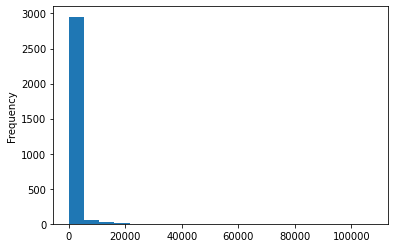

In [11]:
table['cases1'].plot.hist(bins=20)


In case you're confused by the emptiness to the right of the graph, our histogram set aside bins because there are counties with up to (and over) 100,000 cases. They're just so few that they don't even register on the graph. If you needed confirmation, we'd hope to identify *these* as outliers.

With this in mind, we'd expect our z-scores to have a little bit of trouble identifying points that aren't particularly far away from the norm, but maybe the humble z will surprise us.

For this first example, I will only compare the z-score and the isolation forest. It is not feasible to perform a regression on a single dimension, and even if I were to attempt to duplicate the data (as I am doing so with the forest), regressing the data onto itself would lead to every point falling exactly on the regression line (i.e. residuals of zero across the board), and therefore not identifying any points with the Cook's Distance method. As such, we rule out Cook's distance as a method that can be used on one dimensional data.




Modeling the data


In [12]:
first_z_outliers, first_z_speed = first_z(table)

first_forest_outliers, first_forest_speed = first_forest(table)


Plotting our models to visualize the outliers


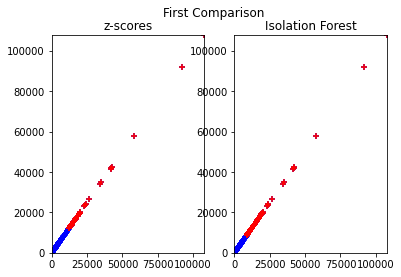

In [13]:
fig, axs = plt.subplots(1,2)
fig.suptitle('First Comparison')

# Plotting the z-score results
axs[0].scatter(table['cases1'], table['cases2'], c= 'b', marker = '+', label = 'Data')
axs[0].scatter(first_z_outliers['cases1'], first_z_outliers['cases2'], c= 'r', marker = '+', label = 'Outliers')
axs[0].set_title('z-scores')
axs[0].set_ylim(0,max(table['cases2']+.001))
axs[0].set_xlim(0,max(table['cases1']+.01))

# Plotting the Isolation Forest results
axs[1].scatter(table['cases1'], table['cases2'], c= 'b', marker = '+', label = 'Data')
axs[1].scatter(first_forest_outliers['cases1'], first_forest_outliers['cases2'], c= 'r', marker = '+', label = 'Outliers')
axs[1].set_title('Isolation Forest')
axs[1].set_ylim(0,max(table['cases2']+.001))
axs[1].set_xlim(0,max(table['cases1']+.01))

fig.show()


Plotting the Isolation Forest results



Well we certainly sliced the biggest data points here - LA and Cook counties (the two far outliers), but it's a little hard to tell how effective each model was.

For reference, it appears that the z-score method identified 38 points (1.2%), while the forest identified 62 points (2%, or exactly our contamination level). As expected, the z-score trended a little conservative on points far away from the norm, and the forest performed exactly as expected.


In [14]:
print(len(first_z_outliers))
print(len(first_forest_outliers))

38
62



    Speed check!


In [15]:
print(first_z_speed)
print(first_forest_speed)

--- 0.011416435241699219 seconds ---
--- 5.886183023452759 seconds ---


Looks like the z-score performed significantly faster in this operation, which doesn't even account for the time spent hyperparamter tuning the forest. If we were looking to indicate which model to choose, particularly for a larger data set, the z-score appears to be clearly superior on one-dimensional data, unless we had specific reason to modify our contamination (though, this can also be mitigated by simply selecting a different z-score cut off).


# Second Example

Bivariate data makes this a little more interesting. We can finally try using cook's distance, since it is possible to regress two variables now, and maybe have a little more luck with standardization. Let's compare county cases and deaths, and this time we'll control for population in each county to tighten up the data and make it a little more interesting for the models.


In [16]:
table = second_table(con)

second_z_outliers, second_z_speed = second_z(table)

second_forest_outliers, second_forest_speed = second_forest(table)

first_cooks_outliers, first_cooks_speed = first_cook(table)



Plotting our models to visualize the outliers


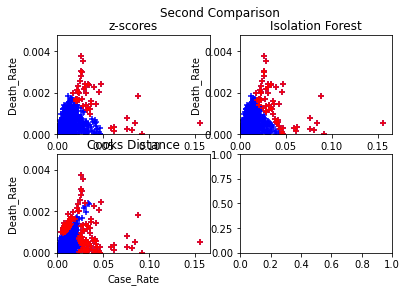

In [17]:
fig, axs = plt.subplots(2,2)
fig.suptitle('Second Comparison')

# Plotting our Cook's Distance results
axs[1, 0].scatter(table['Case_Rate'], table['Death_Rate'], c= 'b', marker = '+', label = 'Data')
axs[1, 0].scatter(first_cooks_outliers['Case_Rate'], first_cooks_outliers['Death_Rate'], c= 'r', marker = '+', label = 'Outliers')
axs[1, 0].set_title('Cooks Distance')
axs[1, 0].set_ylim(0,max(table['Death_Rate']+.001))
axs[1, 0].set_xlim(0,max(table['Case_Rate']+.01))
axs[1, 0].set_xlabel('Case_Rate')
axs[1, 0].set_ylabel('Death_Rate')

# Plotting our z-score results
axs[0, 0].scatter(table['Case_Rate'], table['Death_Rate'], c= 'b', marker = '+', label = 'Data')
axs[0, 0].scatter(second_z_outliers['Case_Rate'], second_z_outliers['Death_Rate'], c= 'r', marker = '+', label = 'Outliers')
axs[0, 0].set_title('z-scores')
axs[0, 0].set_ylim(0,max(table['Death_Rate']+.001))
axs[0, 0].set_xlim(0,max(table['Case_Rate']+.01))
axs[0, 0].set_xlabel('Case_Rate')
axs[0, 0].set_ylabel('Death_Rate')

# Plotting our Isolation Forest results
axs[0, 1].scatter(table['Case_Rate'], table['Death_Rate'], c= 'b', marker = '+', label = 'Data')
axs[0, 1].scatter(second_forest_outliers['Case_Rate'], second_forest_outliers['Death_Rate'], c= 'r', marker = '+', label = 'Outliers')
axs[0, 1].set_title('Isolation Forest')
axs[0, 1].set_ylim(0,max(table['Death_Rate']+.001))
axs[0, 1].set_xlim(0,max(table['Case_Rate']+.01))
axs[0, 1].set_xlabel('Case_Rate')
axs[0, 1].set_ylabel('Death_Rate')

fig.show()


This fascinating graph is where we begin to see the underlying mathematics at work. The z-scores and isolation forest identify outlying points from the origin. We'd expect the forest to do this, as it eventually breaks down to drawing a line to isolate ~2% of the points on the graph when all is said and done (albeit, 1000 times). That looks like a pretty straight line to me.

The z-scores once again tracked conservative, perhaps even more so this time. We'd expect this to be the case, as averaging scores means that a z-score that is very close to normal in one dimension is likely to obscure a point that may be a notable outlier in the other dimension. Still, it's surprising to see how similarly it performed to the much more advanced, and significantly slower ensemble method.

The newly added Cook's Distance is the obvious outlier of our outliers. However, it is performing exactly one may expect here because it identifies points that deviate from the linear trend line of the data. Mre importantly, it does not identify points laying on this line, no matter how far they are from the bulk of the data. This is where it pays to know *why* you're choosing your model. If we were to narrow down a hypothesis to explore for this data, this method could be incredibly concerning, or perhaps notably more robust than the other models. For instance, if we were interested in generalizing expectations for average exposure at the county level with this data, our outlying point(s) with many more cases and deaths would be missed - leading our model to severe overestimates. But, if we wanted to identify counties which are deviating (positively or negatively) from the anticipated ratio of cases that turn into deaths, our other tools would pale in comparison to this one.


Second speed test!


In [18]:
print(second_z_speed)
print(second_forest_speed)
print(first_cooks_speed)

--- 0.013613224029541016 seconds ---
--- 5.627500772476196 seconds ---
--- 4.131526708602905 seconds ---



It's surprising to see that the z-score is still so significantly faster, despite us tripling the necessary number of calculations to perform it. Also of note, calculating Cook's Distance is less comoutationally expensive than the forest in this instance.




# Third Example

We're not really doing predictive modeling here, but it might be fun to throw in a related demographic variable. I've read that opening up food service industries too early, or not regulating them effectively, may be one of the driving causes of the virus. In a three dimensional example, it might be interesting to see how this correlates with rate of cases and deaths. Let's add the percent of the county that works in food service for this example.

Once we start adding increased dimensionality, it becomes increasingly difficult to apply z-scores, and to visually see our outliers. But we'll plot it in 3d and attempt to analyze.

As a note, null values in the Census data were replaced with a minimum value, since nulls in Census data indicate that the data was just too small to be included without revealing the identities of individuals.


In [19]:
table = third_table(con)

third_z_outliers, third_z_speed = third_z(table)

third_forest_outliers, third_forest_speed = third_forest(table)

second_cooks_outliers, second_cooks_speed = second_cook(table)

We'll break up the three 3d plots into their own images here. After toying with it a bit, attempting to plot three 3d subplots together was visually dizzying for me.
    
    
Plotting our Cook's Distance results


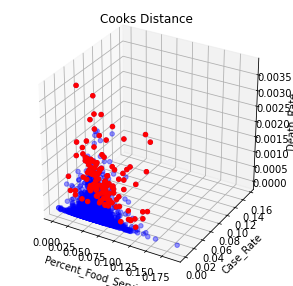

In [20]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Cooks Distance')
ax.set_xlabel('Percent_Food_Service')
ax.set_ylabel('Case_Rate')
ax.set_zlabel('Death_Rate')
sp = ax.scatter(table['Percent_Food_Service'], table['Case_Rate'], table['Death_Rate'], c='b', alpha = .4)
sp = ax.scatter(second_cooks_outliers['Percent_Food_Service'], second_cooks_outliers['Case_Rate'], second_cooks_outliers['Death_Rate'], c='r', alpha = 1)

fig.show()


    Plotting our z-score results


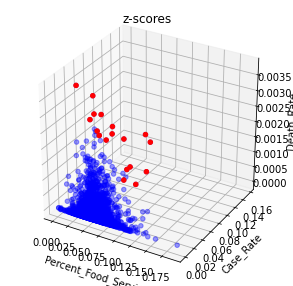

In [21]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('z-scores')
ax.set_xlabel('Percent_Food_Service')
ax.set_ylabel('Case_Rate')
ax.set_zlabel('Death_Rate')
sp = ax.scatter(table['Percent_Food_Service'], table['Case_Rate'], table['Death_Rate'], c='b', alpha = .4)
sp = ax.scatter(third_z_outliers['Percent_Food_Service'], third_z_outliers['Case_Rate'], third_z_outliers['Death_Rate'], c='r', alpha = 1)

fig.show()


    Plotting our Isolation Forest results


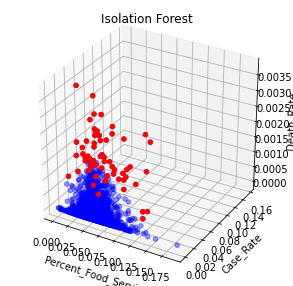

In [22]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Isolation Forest')
ax.set_xlabel('Percent_Food_Service')
ax.set_ylabel('Case_Rate')
ax.set_zlabel('Death_Rate')
sp = ax.scatter(table['Percent_Food_Service'], table['Case_Rate'], table['Death_Rate'], c='b', alpha = .4)
sp = ax.scatter(third_forest_outliers['Percent_Food_Service'], third_forest_outliers['Case_Rate'], third_forest_outliers['Death_Rate'], c='r', alpha = 1)

fig.show()

Looking carefully at the Cook's Distance, we can see where our 3-dimensional trend line would fall based on the streak of blue points. Clearly it is the most aggressive of the methods seen, with notably more points selected than the other two. Interestingly, it appears to identify many more points along the z-axis than the others, probably in no small part due to the z's trend.
    
The average z-score unfortunately fell a little flat here. It picked out fringe cases for sure, but not many. Worse yet, it missed some very obvious outlying points by the eyeball test. As noted above, this could be a result of the points being close to the norm along one (or two) axes, leading to a low average score. Another possibility is the fundemental flaw of averaging scores, as any zero in the calculation will result in an average z-score of zero. While a rare possibility, as we increase the dimensionality of points, we increase the chances of this happening - thus giving us a greater incidence of Type II errors.
    
It looks like 3-dimensional data is where the isolation forest begins to shine. It outperformed the z-scores at a similar game of pulling points far from the origin of the cloud. Depending on use cases, it would have outperformed Cook's as well. Still, it appears to have also missed some obvious points along the axis, which would require tuning of our hyperparameters to remedy (instead of lazily applying a generalized model). If nothing else, this should give data scientists confidence that they won't be replaced with out of the box models just yet. 


Third speed test!


In [23]:
print(third_z_speed)
print(third_forest_speed)
print(second_cooks_speed)

--- 0.019991159439086914 seconds ---
--- 5.85966157913208 seconds ---
--- 4.15242862701416 seconds ---


Once again, the standard scores are blazing fast, comparatively speaking, and the clear winner in the speed vs results trade off. Cook's Distance is relatively slower compared to the forest, as we'd expect because it becomes computationally expensive to perform with much data, while forests are comparatively very effective with many points.


# Conclusion

Our tests seem to show, as expected, that much consideration should be given when selecting a model for anomaly detection. While simply a chore for many before beginning investigations or paring off points that they do not want to include in a model, the anomaly detection process can be very involved as the amount of data rises. Even with the simplistic data set used here, we were able to define clear differences in the data parsed based on our selection of model.

If the goal of anomaly detection is to simply normalize the data by removing outlying points, the obvious most effective answer is a well tuned forest. However, if our goal is to maintain the integrity of a trendline, Cook's is the bar-none approach even with multi-dimensional data, despite how hot the most complicated machine learning models may be. For a very fast, simple, or ad-hoc analysis, it appears to be wasteful to not use z-scores except in particular circumstances - and even then, we had surprising (eye-ball) success despite our data shape biasing the mean. 
    
It is my hope that all reading this will think critically about how and why they may choose to select outlying points instead of relying on a one size fits all approach. Furthermore, I hope that they challenge the underlying assumptions of their selection criteria and the potential biases that their model may inject into the results of what may otherwise seem like a straightforwad task.